#### Учебный проект в рамках профессии Data Science Яндекс Практикума

## Разработка рекомендаций для интернет-магазина "Стримчик" 

В этом проекте мы должны проанализировать деятельность интернет-магазина «Стримчик», продающего по всему миру компьютерные игры. Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года и мы должны составить рекомендации на следующий, 2017 год.

Приступим к анализу. 

План наших действий: 

* Первым шагом мы проанализируем имеющеся данные, поймем где есть пропуски и как они там появились.
* Далее мы преобразуем данные, чтобы их было удобнее анализировать.
* После этого мы сможем визуализировать данные и изучать взаимосвязи различных факторов, их корреляции.
* В итоге мы попробуем подвести выводы и сформировать рекомендации на следующий год.

### Шаг 1. Откроем файл с данными и изучим  общую информацию


#### Описание данных 

* Name — название игры 
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы долларов)
* EU_sales — продажи в Европе (миллионы долларов)
* JP_sales — продажи в Японии (миллионы долларов)
* Other_sales — продажи в других странах (миллионы долларов)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. 


In [1]:
import math
import pandas as pd 
import matplotlib as plt 
import matplotlib.pyplot as plot 
import numpy as np
import seaborn as sns
from scipy import stats as st
from math import factorial
 
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
data.head(5)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Промежуточные выводы**

После открытия датасета мы видим, что в таблице 16713 строк с данными о названиях игр, их платформах, годе выпуска и мнению критиков и игроков в разных регионах. 

К сожалению, хуже всего обстоят дела с полнотой данных по рейтингам: видимо, это поле необязательное, либо есть не так много профессиональных критиков, которые могут составить полноценный обзор на игры. 

Из плюсов: финансовые результаты довольно подробные, а значит мы сможем проанализировать популярность игр на разных континентах.

-- 

Причин для появления пропусков может быть много: например, они могли потеряться при объединении результатов из разных регионов или за ввод данных посадили новых сотрудников магазина, которые невнимательно заполнили поля с названиями. 

Потерь строчек в полях с названием и платформой явно можно было бы избежать: кажется, что это просто человеческий фактор и кто-то действительно при вводе пропустил несколько значений с названиями. 

Пропуски в рейтингах, как мы предположили выше, скорее всего систематичные и неслучайные: их не требуют и не собирают в обязательном порядке, хотя они могли бы быть полезными, это явная "зона роста" для сбора данных.

Неправильный формат в датах точно нужно лечить он неслучаен и затронул все данные: к сожалению, мы не видим дней и времени покупок, а с ними мы могли бы лучше планировать сезонные релизы или, например, присмотреться когда больше вероятность совершить покупку: утром в понедельник или вечером в субботу.   

### Шаг 2. Подготовим данные

* Заменим названия столбцов (приведите к нижнему регистру);
* Преобразуем данные в нужные типы;
* Обработаем пропуски при необходимости:
* Объясним, почему заполнили пропуски определённым образом или почему не стали это делать;
* Опишем причины, которые могли привести к пропускам;
* Отдельно разберем значение tbd;
* Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [2]:
# Заменим названия столбцов (приведем их к нижнему регистру)

data.rename(columns = {'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release', 'Genre':'genre',
               'NA_sales':'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales',
                             'Critic_Score':'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'}, inplace = True)

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Преобразуем данные в нужные типы.
# Посмотрим какие значения есть в столбце year_of_release и приведем их к одному типу (int). Возьмем int для удобства подсчетов.

#print(data['year_of_release'].unique())
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype(int)
pd.to_numeric(data['year_of_release'], errors ='raise')


0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16715, dtype: int64

In [4]:
# tbd = to be discovered, т.е. нельзя оставлять определенную цифру, поэтому для удобства расчетов поставим 0

data['user_score'] = data['user_score'].fillna(0)
data['user_score'] = data['user_score'].replace('tbd', 0)


data['critic_score'] = data['critic_score'].fillna(0)
data['rating'] = data['rating'].fillna(0)

#print (data['user_score'].unique())
#print (data['critic_score'].unique())

In [5]:
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

data['all_sales'] = data['na_sales'] + data['eu_sales'] +  data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,0,31.38


**Промежуточные выводы**

После всех преобразований мы получили таблицу, в которой есть понятные данные по годам, нет значений nan и есть столбец со всеми продажами.

Мы должны помнить, что у нас есть пропущенные значения в полях critic_score, user_score и rating, где они заменены нулевыми значениями. У нас нет достаточной информации, чтобы их восполнить.

### Шаг 3. Проведем исследовательский анализ данных 

* Посмотрим сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
* Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
* Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
* Построем график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишем результат.
* Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.
* Соотнесем выводы с продажами игр на других платформах.
* Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

/Users/armineakhverdyan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Количество выпущенных игр в разные годы'>

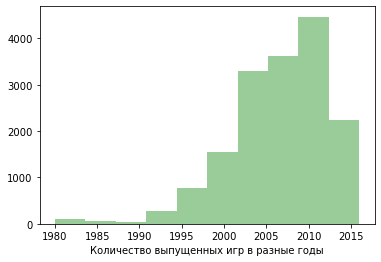

In [6]:
# Посмотрим, сколько игр выпускалось в разные годы

sns.distplot(data['year_of_release'], kde = False, hist_kws={"range":(1980,2016)}, bins = 10, color="g", 
             axlabel="Количество выпущенных игр в разные годы")

Распределение выручки в период с 2006 по 2016 гг. year_of_release
2006    517.71
2007    604.75
2008    671.50
2009    658.82
2010    590.13
2011    507.58
2012    355.84
2013    361.24
2014    331.53
2015    267.98
2016    129.94
Name: all_sales, dtype: float64
 - - -
Распределение количества выпущенных игр с 2006 по 2016 гг. year_of_release
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


/Users/armineakhverdyan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Гистограмма количества выпущенных игр (зеленым) + график их прибыли (синим)'>

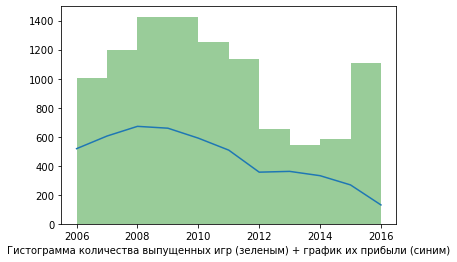

In [7]:
# Cузим данные до последних 10 лет, изучать спрос ранее этого периода нет смысла.
# Если взять дата-сет меньше, мы можем не увидеть взлеты и падения разных платформ, проверить их устойчивость на рынке.

current_years = data.query('year_of_release > 2005')
platforms_grouped_by_years = current_years.groupby('year_of_release')['all_sales'].sum()
games_grouped_by_years = current_years.groupby('year_of_release')['name'].count()
print('Распределение выручки в период с 2006 по 2016 гг.', platforms_grouped_by_years)
print(' - - -')
print('Распределение количества выпущенных игр с 2006 по 2016 гг.', games_grouped_by_years)

platforms_grouped_by_years.plot()
sns.distplot(data['year_of_release'], kde = False, bins = 10,  hist_kws={"range":(2006,2016)}, color="g", 
             axlabel="Гистограмма количества выпущенных игр (зеленым) + график их прибыли (синим)")


Посмотрим, как менялись продажи по платформам. 
Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. 


Самые прибыльные платформы с 2006 по 2016 гг. platform
X360    952.99
PS3     931.34
Wii     891.18
DS      655.35
PS4     314.14
PS2     265.80
3DS     257.81
PSP     238.63
PC      163.42
XOne    159.32
Name: all_sales, dtype: float64


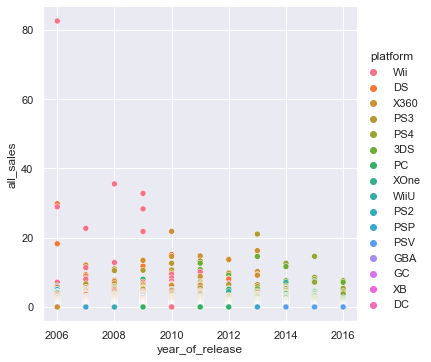

In [8]:
top_platforms = current_years.groupby('platform').sum().sort_values(by = 'all_sales', ascending = False).head(10)
print('Самые прибыльные платформы с 2006 по 2016 гг.', top_platforms['all_sales'])

sns.set()
sns.relplot(x="year_of_release", y="all_sales", hue="platform", data=current_years)

Самой прибыльной за все время анализа можно смело считать X360, затем идет PS3 и Wii.
Самый яркий успех (и отрыв от остальных платформ) мы видим у Wii в 2006 г. В 2007 и в 2008 ситуация повторяется, но уже без такого большого отрыва. После 2010 все платформы идут практически ровно, но чаще лидируют PS3 и PS4.

In [9]:
platforms_by_years = current_years.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc= 'sum')
print(platforms_by_years)
platforms_by_years

platform           3DS    DC      DS   GBA     GC     PC     PS2     PS3  \
year_of_release                                                            
2006               NaN   NaN  119.81  5.28  11.26   2.85  103.42   20.96   
2007               NaN  0.02  146.94  3.40   0.27   9.28   75.99   73.19   
2008               NaN  0.04  145.31   NaN    NaN  12.42   53.90  118.52   
2009               NaN   NaN  119.54   NaN    NaN  16.91   26.40  130.93   
2010               NaN   NaN   85.02   NaN    NaN  24.28    5.64  142.17   
2011             63.20   NaN   26.18   NaN    NaN  35.03    0.45  156.78   
2012             51.36   NaN   11.01   NaN    NaN  23.22     NaN  107.36   
2013             56.57   NaN    1.54   NaN    NaN  12.38     NaN  113.25   
2014             43.76   NaN     NaN   NaN    NaN  13.28     NaN   47.76   
2015             27.78   NaN     NaN   NaN    NaN   8.52     NaN   16.82   
2016             15.14   NaN     NaN   NaN    NaN   5.25     NaN    3.60   

platform   

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,
2006,NaN,NaN,119.81,5.28,11.26,2.85,103.42,20.96,NaN,55.32,NaN,137.15,NaN,51.62,10.04,NaN
2007,NaN,0.02,146.94,3.40,0.27,9.28,75.99,73.19,NaN,46.93,NaN,152.77,NaN,95.41,0.55,NaN
2008,NaN,0.04,145.31,NaN,NaN,12.42,53.90,118.52,NaN,34.55,NaN,171.32,NaN,135.26,0.18,NaN
2009,NaN,NaN,119.54,NaN,NaN,16.91,26.40,130.93,NaN,37.78,NaN,206.97,NaN,120.29,NaN,NaN
2010,NaN,NaN,85.02,NaN,NaN,24.28,5.64,142.17,NaN,35.04,NaN,127.95,NaN,170.03,NaN,NaN
2011,63.20,NaN,26.18,NaN,NaN,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN,NaN
2012,51.36,NaN,11.01,NaN,NaN,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN,NaN
2013,56.57,NaN,1.54,NaN,NaN,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,NaN,18.96
2014,43.76,NaN,NaN,NaN,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,NaN,54.07


In [10]:
#За какой характерный срок появляются новые и исчезают старые платформы?

min_year_of_release = current_years.pivot_table(index='platform', values='year_of_release', aggfunc= 'min')
max_year_of_release = current_years.pivot_table(index='platform', values='year_of_release', aggfunc= 'max')
platform_life = max_year_of_release - min_year_of_release
median_platform_life = platform_life.median().astype(int)

print('В среднем платформы живут всего {} лет.'.format(median_platform_life[0]))

В среднем платформы живут всего 5 лет.


Какие платформы лидируют по продажам, растут или падают?


In [11]:
# Платформы, которые лидируют по продажам
platforms_sales = current_years.pivot_table(index='platform', values='all_sales', aggfunc= 'sum')
print('10 самых прибыльных платформ с 2006 по 2016 гг: ')
top_10_rising_platforms = platforms_sales.sort_values(by = 'all_sales', ascending = False).head(10)
print(top_10_rising_platforms)

print('- - -')
# Платформы, которые показали меньший коммерческий успех
failing_platforms = current_years.pivot_table(index='platform', values='all_sales', aggfunc= 'sum')
print('10 самых убыточных платформ с 2006 по 2016 гг:')
top_10_failing_platforms =  failing_platforms.sort_values(by = 'all_sales', ascending = True).head(10)
print(top_10_failing_platforms)

10 самых прибыльных платформ с 2006 по 2016 гг: 
          all_sales
platform           
X360         952.99
PS3          931.34
Wii          891.18
DS           655.35
PS4          314.14
PS2          265.80
3DS          257.81
PSP          238.63
PC           163.42
XOne         159.32
- - -
10 самых убыточных платформ с 2006 по 2016 гг:
          all_sales
platform           
DC             0.06
GBA            8.68
XB            10.77
GC            11.53
PSV           53.81
WiiU          82.19
XOne         159.32
PC           163.42
PSP          238.63
3DS          257.81


Text(0.5, 1.0, 'Диаграмма размаха всех продаж игр')

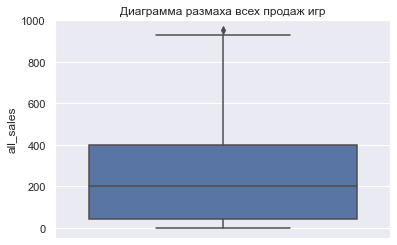

In [12]:
#Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 

sns.boxplot( y="all_sales", data = platforms_sales ).set_title('Диаграмма размаха всех продаж игр')


Прибыль платформ варьируются от 50 до 400 миллионов долларов. Чаще всего они приносят 200 млн. долларов.
Максимальные значения мы видели в таблицах выше: прибыли может не быть совсем, так и достигать в почти 900 млн. долларов.

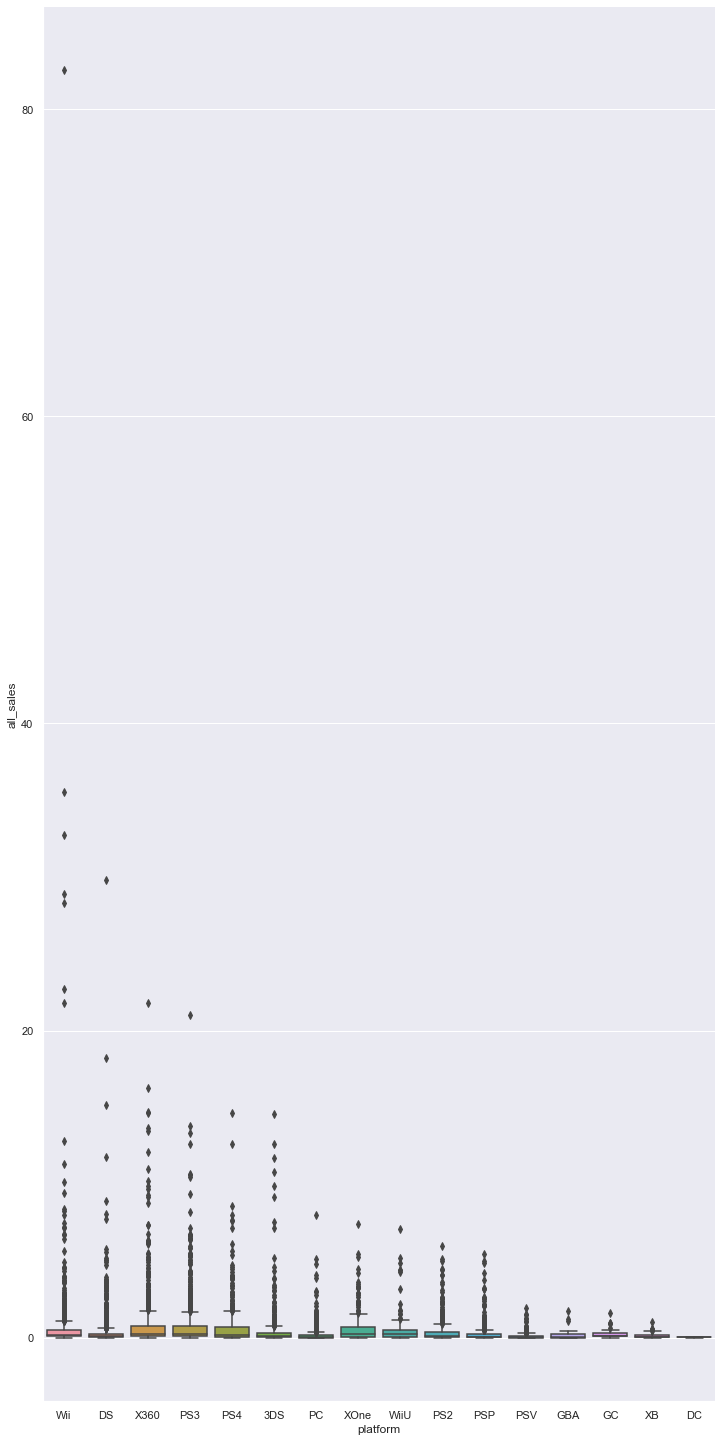

In [13]:
sns.catplot(x = 'platform', y = 'all_sales', data = current_years, kind = 'box', height = 20, aspect = 0.5)

В этом ящике с усами выше мы можем подробнее увидеть продажи каждой из платформ. 
Видим вырвавшиеся вперед значения уже знакомой нам платформы Wii, дальше идут DS, X360, PS3, PS4. 

          all_sales
platform           
3DS        0.503535
DC         0.030000
DS         0.331152
GBA        0.192889
GC         0.262045
PC         0.210593
PS2        0.330186
PS3        0.713124
PS4        0.801378
PSP        0.220342
PSV        0.125431
Wii        0.692986
WiiU       0.559116
X360       0.785000
XB         0.163182
XOne       0.645020
Средняя прибыль платформ за все время работы составляет: all_sales    0.410374
dtype: float64 млн. долларов


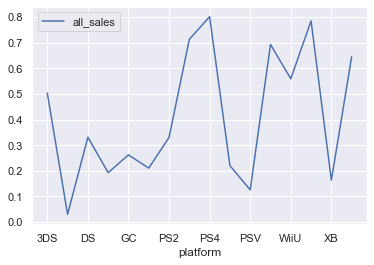

In [14]:
#Велика ли разница в продажах? 

platforms_mean_sales = current_years.pivot_table(index='platform', values='all_sales', aggfunc= 'mean')
print(platforms_mean_sales)
platforms_mean_sales.plot()
mean_sales = platforms_mean_sales.mean()

print('Средняя прибыль платформ за все время работы составляет: {} млн. долларов'.format(mean_sales))

Для рекомендаций на следующий год я бы советовала приглядеться к прибыли платформ за последние три года (график top_platforms и сводная таблица platforms_by_years в самом начале этого блока).

PS4, WiiU, Xone показывают хорошие результаты, а вот популярность Wii, 3DS, PC, PS3, PSV, X360 идет на спад - они уже были популярны довольно долгое время и их жизненный цикл на рынке похоже приходит к концу. 

In [15]:
# Проанализируем данные, в которых есть проставленные оценки в user_score и critic_score

def number(row):
    if str(row['user_score']).isdigit() == True:
        return row['user_score']
    else:
        return 0

current_years['user_score_upd'] = current_years.apply(number, axis = 1)
print(current_years.head())

                    name platform  year_of_release     genre  na_sales  \
0             Wii Sports      Wii             2006    Sports     41.36   
2         Mario Kart Wii      Wii             2008    Racing     15.68   
3      Wii Sports Resort      Wii             2009    Sports     15.61   
6  New Super Mario Bros.       DS             2006  Platform     11.28   
7               Wii Play      Wii             2006      Misc     13.96   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  all_sales  \
0     28.96      3.77         8.45          76.0          8      E      82.54   
2     12.76      3.79         3.29          82.0        8.3      E      35.52   
3     10.93      3.28         2.95          80.0          8      E      32.77   
6      9.14      6.50         2.88          89.0        8.5      E      29.80   
7      9.18      2.93         2.84          58.0        6.6      E      28.91   

  user_score_upd  
0              8  
2              0  
3          

<ipython-input-15-dbd761d613e5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_years['user_score_upd'] = current_years.apply(number, axis = 1)


In [16]:
#Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

print('Изучим, как влияют на продажи платформ отзывы пользователей и критиков (на примере самых популярных платформ)')
data_with_scores = current_years.query('critic_score != 0' and 'user_score_upd != 0')
X360_scores = data_with_scores.query('platform == "X360"')
PS3_scores = data_with_scores.query('platform == "PS3"')
Wii_scores = data_with_scores.query('platform == "Wii"')
DS_scores = data_with_scores.query('platform == "DS"')
PS4_scores = data_with_scores.query('platform == "PS4"')

# Сначала мы посчитали средние оценки критиков и пользователей и увидели, что они напоминают среднюю температуру по больнице
# Поэтому будем обращать внимание на медианы
# Выведем по 5 прибыльным платформам комбинированную оценку критиков и пользователей (сложим их медианы вместе и найдем среднее)

print('- - -')
print('Медианная оценка критиков и пользователей по платформе X360:', (round(X360_scores['critic_score'].median()/10) +
                                                                       round(X360_scores['user_score_upd'].median())) /2 )  
print('Общая прибыль платформы  X360: ', round(platforms_sales['all_sales']['X360']))

print('- - -')
print('Медианная оценка критиков и пользователей по платформе PS3:', (round(PS3_scores['critic_score'].median()/10) +
                                                                       round(PS3_scores['user_score_upd'].median())) /2 )  
print('Общая прибыль платформы  PS3: ', round(platforms_sales['all_sales']['PS3']))
print('- - -')

print('Медианная оценка критиков и пользователей по платформе Wii:', (round(Wii_scores['critic_score'].median()/10) +
                                                                       round(Wii_scores['user_score_upd'].median())) /2 ) 
print('Общая прибыль платформы  Wii: ', round(platforms_sales['all_sales']['Wii']))
print('- - -')

print('Медианная оценка критиков и пользователей по платформе DS:', (round(DS_scores['critic_score'].median()/10) +
                                                                       round(DS_scores['user_score_upd'].median())) /2 ) 
print('Общая прибыль платформы  DS: ', round(platforms_sales['all_sales']['DS']))

print('- - -')
print('Медианная оценка критиков и пользователей по платформе PS4:', (round(PS4_scores['critic_score'].median()/10) +
                                                                       round(PS4_scores['user_score_upd'].median())) /2 ) 
print('Общая прибыль платформы  PS4: ', round(platforms_sales['all_sales']['PS4']))


Изучим, как влияют на продажи платформ отзывы пользователей и критиков (на примере самых популярных платформ)
- - -
Медианная оценка критиков и пользователей по платформе X360: 7.0
Общая прибыль платформы  X360:  953
- - -
Медианная оценка критиков и пользователей по платформе PS3: 6.5
Общая прибыль платформы  PS3:  931
- - -
Медианная оценка критиков и пользователей по платформе Wii: 6.5
Общая прибыль платформы  Wii:  891
- - -
Медианная оценка критиков и пользователей по платформе DS: 6.5
Общая прибыль платформы  DS:  655
- - -
Медианная оценка критиков и пользователей по платформе PS4: 7.0
Общая прибыль платформы  PS4:  314


У платформы может быть рейтинг 7.0 и при этом прибыль в 953 млн. долларов и в 314 млн. долларов. 
Кажется, что рейтингам и оченкам не очень стоит доверять, но на всякий случай проверим есть ли корреляция между ними.

In [17]:
#Постройте диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

data_with_scores['user_score'] = data_with_scores['user_score'].astype(int)
data_with_scores['critic_score'] = data_with_scores['critic_score'].astype(int)
data_with_scores['combined_scores'] = data_with_scores['critic_score']/10 + data_with_scores['user_score']/ 2
data_with_scores.head(5)

<ipython-input-17-002d7252ee25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_scores['user_score'] = data_with_scores['user_score'].astype(int)
<ipython-input-17-002d7252ee25>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_scores['critic_score'] = data_with_scores['critic_score'].astype(int)
<ipython-input-17-002d7252ee25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,user_score_upd,combined_scores
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54,8,11.6
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77,8,12.0
66,Halo 4,X360,2012,Shooter,6.65,2.28,0.04,0.74,87,7,M,9.71,7,12.2
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5,E,7.60,5,11.0
103,Just Dance,Wii,2009,Misc,3.48,2.99,0.00,0.73,49,8,E10+,7.20,8,8.9


In [18]:
#Соотнесите выводы с продажами игр на других платформах

correlation_scores_vs_money =  data_with_scores['combined_scores'].corr(data_with_scores['all_sales'])
print('Корреляция между общими оценками и прибылью составила: ', correlation_scores_vs_money)

if (correlation_scores_vs_money < .5):
    print("Корреляция не очень сильна: взаимосвязи между оценками и прибылью нет.")
else:
    print("Есть явная корреляция между прибылью и оценками критиков и пользователей.")
    
    
# udp. Изучим корреляцию между оценками и приыблью на примере трех платформ, 
# которых мы видим потенциально успешными в следующем году: PS4, WiiU, Xone   
print('')
print('Посмотрим на корреляцию между рейтингами и прибылью на платформах PS4, WiiU, Xone')
print('')
correlation_scores_vs_money_for_PS4 = data_with_scores.query('platform == "PS4"')['combined_scores'].corr(data_with_scores.query('platform == "PS4"')['all_sales'])
correlation_scores_vs_money_for_WiiU = data_with_scores.query('platform == "WiiU"')['combined_scores'].corr(data_with_scores.query('platform == "WiiU"')['all_sales'])
correlation_scores_vs_money_for_Xone  = data_with_scores.query('platform == "Xone"')['combined_scores'].corr(data_with_scores.query('platform == "Xone"')['all_sales'])


print('Корреляция между оценками и прибылью PS4 составила:', correlation_scores_vs_money_for_PS4)
print('Корреляция между оценками и прибылью WiiU составила:', correlation_scores_vs_money_for_WiiU)
print('Корреляция между оценками и прибылью Xone составила:', correlation_scores_vs_money_for_Xone)

Корреляция между общими оценками и прибылью составила:  0.1129993268986656
Корреляция не очень сильна: взаимосвязи между оценками и прибылью нет.

Посмотрим на корреляцию между рейтингами и прибылью на платформах PS4, WiiU, Xone

Корреляция между оценками и прибылью PS4 составила: 0.1964488019792073
Корреляция между оценками и прибылью WiiU составила: 0.4454802991270377
Корреляция между оценками и прибылью Xone составила: nan


---
## Комментарий от наставника

Нам надо рассмотреть влияние оценок на выручку по-отдельности. Посмотри на корреляции отзывов критиков и пользователей и выручки по популярным платформам. 

---

**upd** Где-то корреляция оказалась выше средней, но все равно ниже 0.5, поэтому все еще не будем делать выводы о явной связи между этими показателями. У Xone не оказалось в наличии нужных данных для расчетов. 

<font color=blue> Верно, ситуация по платформам примерно похожа. 
    
---

              all_sales
genre                  
Action          1116.65
Sports           793.85
Shooter          717.04
Misc             554.86
Role-Playing     522.40
Racing           299.00
Platform         279.74
Simulation       220.65
Fighting         188.42
Adventure        141.35
Puzzle            89.92
Strategy          73.14


<AxesSubplot:xlabel='genre'>

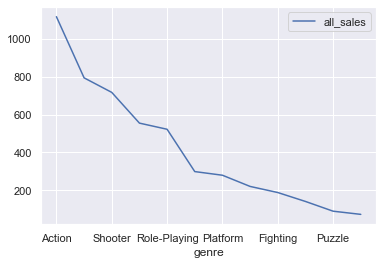

In [19]:
#Посмотрим на общее распределение игр по жанрам. 
#Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

genre_sales = current_years.pivot_table(index='genre', values='all_sales', aggfunc= 'sum')
top_genres =  genre_sales.sort_values(by = 'all_sales', ascending = False)
print(top_genres)
top_genres.plot()

**Промежуточные выводы**

Мы взяли период с 2006 по 2016 гг, чтобы увидеть взлеты и падения на актуальный для нас промежуток времени.
Платформы в среднем живут 5 лет: за это время они могут быть на пике, а потом уйти. Лидеров, которые были бы на пике на протяжение десятилетия мы явно не увидели. 

Суммарные продажи были лучше всего у платформ X360, PS3, Wii, DS, PS4, хуже всего: у DC, GBA, XB, GC. 
В среднем платформы могут получить прибыль в 200 млн. долларов (с размахом от 50 до 400 млн. долларов). Понятно, что платформы могут быть убыточными и совсем провальными, по этим данным мы не увидим всего дна, т.к. есть маленькие платформы, которые не попали в датасет. Максимальную прибыль - в 952 млн. долларов мы увидели у X360. Это не выброс и не аномалия, другие игроки (PS3, Wii) практически наступают платформе на пятки. 

Оценки критиков и пользователей практически не влияют на прибыльность, корреляция между ними очень слаба. Возможно, свою роль сыграла и неполнота данных: если бы каждый оставлял оценку, мы бы увидели другую картину. 

С жанрами все стало более-менее понятно: прибыльные жанры: Action, Sports, Shooter, Misc, Role-playing, остальные направления сильно отстают.


### Шаг 4. Составим портрет пользователя каждого региона 

* Определим пользователей каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишем различия в долях продаж.
* Самые популярные жанры (топ-5). Поясним разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Портрет игрока из Европы:
          na_sales
platform          
X360        588.84
Wii         486.87
PS3         390.13
DS          323.99
PS2         114.89
              na_sales
genre                 
Action          530.44
Sports          396.64
Shooter         373.13
Misc            285.06
Role-Playing    199.63
        na_sales
rating          
E         796.98
M         574.33
T         424.14
E10+      315.40
0         274.50




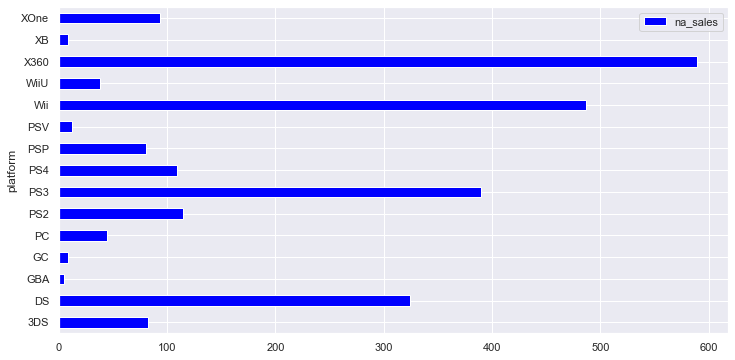

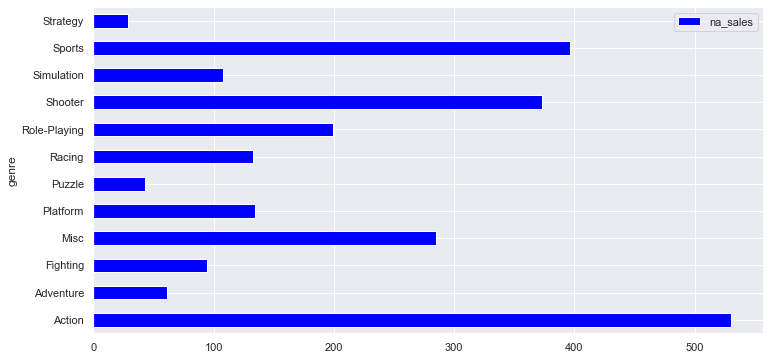

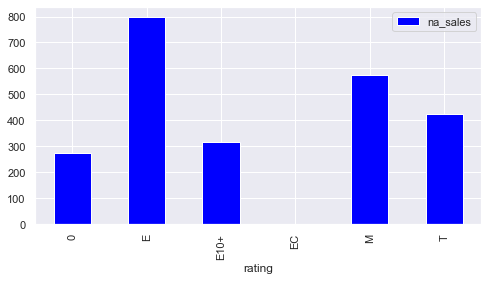

In [20]:
# Данные вне зависимости от рейтинга 

na_users = current_years.query('na_sales != 0')
eu_users = current_years.query('eu_sales != 0')
jp_users = current_years.query('jp_sales != 0')

na_platforms_sales = na_users.pivot_table(index='platform', values='na_sales', aggfunc= 'sum')
na_top_5_platforms = na_platforms_sales.sort_values(by = 'na_sales', ascending = False).head(5)
na_genre_sales = na_users.pivot_table(index='genre', values='na_sales', aggfunc= 'sum')
na_top_5_genres =  na_genre_sales.sort_values(by = 'na_sales', ascending = False).head(5)
na_rating_sales = na_users.pivot_table(index='rating', values='na_sales', aggfunc= 'sum')
na_top_ratings =  na_rating_sales.sort_values(by = 'na_sales', ascending = False).head(5)

print('Портрет игрока из Европы:')
print(na_top_5_platforms)
print(na_top_5_genres)
print(na_top_ratings)
print('')


na_platforms_sales.plot(kind='barh', figsize=(12,6), color = 'blue')
na_genre_sales.plot(kind='barh', figsize=(12,6), color = 'blue')
na_rating_sales.plot(kind='bar', figsize=(8,4), color = 'blue')
print('')



Игроки в Северной Америке предпочитают практически те же платформы, которые лидируют во всем мире, не будем их перечислять еще раз. По жанрам такая же ситуация. В рейтингах лидируют игры для всех (E - everyone, M - Mature, T - Teens) 

Портрет игрока из Европы:
          eu_sales
platform          
PS3         327.21
X360        267.89
Wii         258.32
DS          142.99
PS4         141.09
         eu_sales
genre            
Action     350.70
Sports     251.55
Shooter    238.89
Misc       146.88
Racing     113.39
        eu_sales
rating          
E         461.09
M         398.90
T         235.44
0         227.19
E10+      173.35




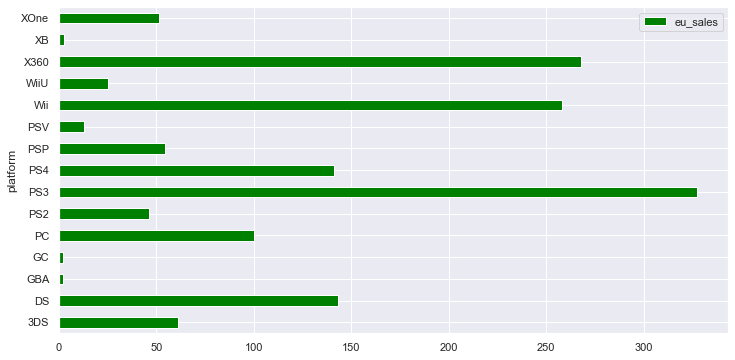

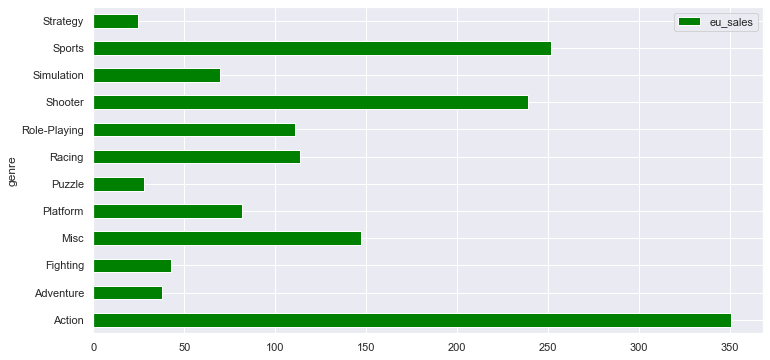

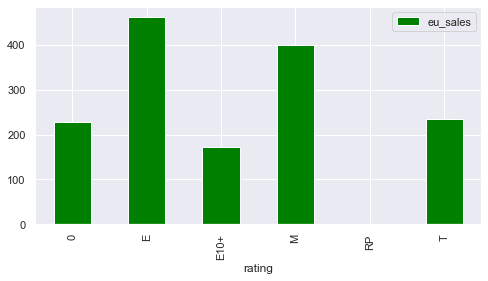

In [21]:
eu_platforms_sales = eu_users.pivot_table(index='platform', values='eu_sales', aggfunc= 'sum')
eu_top_5_platforms = eu_platforms_sales.sort_values(by = 'eu_sales', ascending = False).head(5)
eu_genre_sales = eu_users.pivot_table(index='genre', values='eu_sales', aggfunc= 'sum')
eu_top_genres =  eu_genre_sales.sort_values(by = 'eu_sales', ascending = False).head(5)
eu_rating_sales = eu_users.pivot_table(index='rating', values='eu_sales', aggfunc= 'sum')
eu_top_ratings =  eu_rating_sales.sort_values(by = 'eu_sales', ascending = False).head(5)

print('Портрет игрока из Европы:')
print(eu_top_5_platforms)
print(eu_top_genres)
print(eu_top_ratings)
print('')

eu_platforms_sales.plot(kind='barh', figsize=(12,6), color = 'green')
eu_genre_sales.plot(kind='barh', figsize=(12,6), color = 'green')
eu_rating_sales.plot(kind='bar', figsize=(8,4), color = 'green')
print('')

Игроки в Европе предпочитают платформы PS3, X360, Wii, DS, PS4, картина явно отличается от общемировой. Но первые три строчки в жанрах и рейтингах остаются неизменны, в этом вкусы двух континентов совпадают. 

Портрет игрока из Японии:
          jp_sales
platform          
DS          141.49
3DS         100.62
PS3          79.41
PSP          70.63
Wii          68.28
              jp_sales
genre                 
Role-Playing    170.38
Action          102.07
Misc             64.53
Sports           48.97
Platform         35.20
        jp_sales
rating          
0         276.69
E         120.36
T          83.90
M          43.79
E10+       36.57




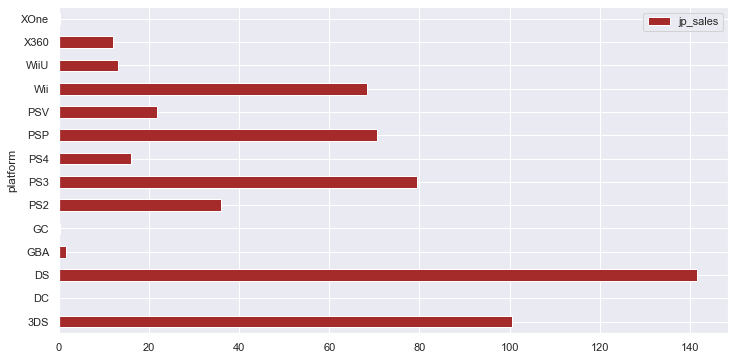

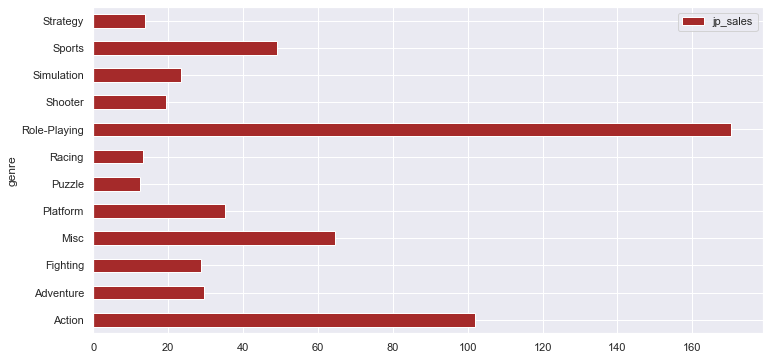

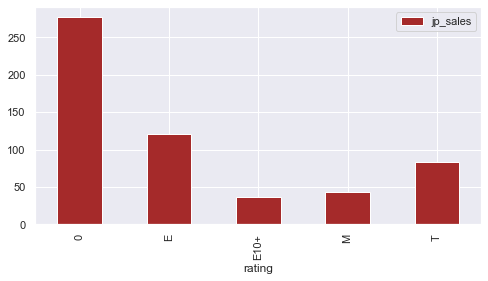

In [22]:
jp_platforms_sales = jp_users.pivot_table(index='platform', values='jp_sales', aggfunc= 'sum')
jp_top_5_platforms = jp_platforms_sales.sort_values(by = 'jp_sales', ascending = False).head(5)
jp_genre_sales = jp_users.pivot_table(index='genre', values='jp_sales', aggfunc= 'sum')
jp_top_genres =  jp_genre_sales.sort_values(by = 'jp_sales', ascending = False).head(5)
jp_rating_sales = jp_users.pivot_table(index='rating', values='jp_sales', aggfunc= 'sum')
jp_top_ratings =  jp_rating_sales.sort_values(by = 'jp_sales', ascending = False).head(5)

print('Портрет игрока из Японии:')
print(jp_top_5_platforms)
print(jp_top_genres)
print(jp_top_ratings)
print('')

jp_platforms_sales.plot(kind='barh', figsize=(12,6), color = 'brown')
jp_genre_sales.plot(kind='barh', figsize=(12,6), color = 'brown')
jp_rating_sales.plot(kind='bar', figsize=(8,4), color = 'brown')
print('')

Игроки в Японии предпочитают совершенно другие платформы: DS, 3DS, PS3, PSP, Wii картина региона отличается от общемировой. Жанры и рейтинги также отличаются: в Японии нужно делать ставку на Role-playing и только потом Action и все остальное. По рейтингам, к сожалению, у нас не самая надежная информация, лидируют пропущенные данные. Но дальше ситуация как у всех - E,M,T. 

### Шаг 5. Проверим  гипотезы

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные. Задайте самостоятельно пороговое значение alpha. 


In [23]:
#print(current_years['platform'].unique())
#print(current_years.head(5))

xbox_one_rating = current_years.query('platform == "XOne"')['critic_score']
pc_rating = current_years.query('platform == "PC"')['critic_score']

alpha = 0.05

results_1 = st.ttest_ind(xbox_one_rating, pc_rating, equal_var = False)
print('p-значение xbox и pc', results_1.pvalue)

if (results_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу о том, что средние рейтинги xbox и pc одинаковые.")
else:
    print("Не получилось отвергнуть нулевую гипотезу о том, что в средние рейтинги xbox и pc одинаковые.")

p-значение xbox и pc 0.04893096810327019
Отвергаем нулевую гипотезу о том, что средние рейтинги xbox и pc одинаковые.


In [24]:
#print(current_years['platform'].unique())

action_rating = current_years.query('genre == "Action"')['critic_score']
sports_rating = current_years.query('genre == "Sports"')['critic_score']

alpha = 0.05

results_2 = st.ttest_ind(action_rating, sports_rating, equal_var = False)
print('p-значение жанров Action и Sports', results_2.pvalue)

if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу о том, что жанры Action и Sports одинаково популярны.")
else:
    print("Не получилось отвергнуть нулевую гипотезу о том, что жанры Action и Sports одинаково популярны.")

p-значение жанров Action и Sports 0.6922204177099625
Не получилось отвергнуть нулевую гипотезу о том, что жанры Action и Sports одинаково популярны.


### Шаг 6. Общий вывод


Наша задача выявить основные факторы, которые влияют на продажи платформ, чтобы выстроить свою линию деятельности в следующем году.

С уверенностью можно сказать, что точно не стоит мониторить рейтинги и гнаться за ними: на прибыль они не влияют. 

А вот на исследовании региональных рынков экономить не стоит: те жанры и платформы, которые пользуются спросом в Америке, явно не подойдут Японии. Важно отметить, что большую часть кассы при этом делает именно Америка, если нужно расставить приоритеты, можно сосредоточиться на ней и распространить линию действий на весь мир. Сработает не очень точно, скорее как план Б.

Рейтинг ESRB, в целом таков: больше прибыли приносят универсальные игры для всех с рейтингом E, потом М для взрослых и T для тинейджеров. Разницы по регионам особенно нет.

Что касается платформ, мы видим, что никто не может долго и уверенно удерживать лидерство, платформы в среднем имеют жизненный цикл в 5 лет. Каждый год показывает места платформ в рейтинге разнятся: они явно зависят от популярности выпущенных игр под эти платформы. Тем не менее, мы выделили основных лидеров десятилетия: X360, PS3, Wii, DS, PS4. 

Рейтинги платформ в разных регионах точно довольно отличаются, но мы также проверили вероятность того, что у двух разных платформ в целом могут быть одинаковые рейтинги, а также, что у разных жанров одинаковая прибыль. Обе гипотезы подтвердить не удалось, т.е. платформы и жанры не стоит связывать друг с другом, вероятность, что разные платформы и разные жанры будут вести себя одинаково очень мала.

В целом можно сказать, что при планировании на следующий год стоит начать с выбора нужного региона и далее изучать данные в нескольких временных разрезах: за 10 лет, за 5 и отдельно за последний год. Такие промежутки дадут понять пристрастия региональных пользователей по жанрам (они будут видны в промежутке 10 лет), по платформам (последние 5 лет), и по самим играм (последний год). На показатели рейтингов, статусы в ESRB при этом полагаться не стоит: во-первых, не везде есть полные данные, во-вторых, они не всегда сходятся с реальностью: подросток может достать диск с рейтингом M, а взрослый играть в EC, критик может намеренно завышать и занижать оценки.
